# Data Handling and Machine Learning Setup

This script imports the necessary libraries for **data handling**, **machine learning preprocessing**, **evaluation**, and **visualization**.

---


In [21]:
# Data handling
import pandas as pd
import numpy as np

# Machine learning (scikit-learn) - only what we need for preprocessing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Visualization
import matplotlib.pyplot as plt

# To make plots look nicer
plt.style.use("seaborn-v0_8")

#  Custom Naive Bayes Classifier - Manual Implementation

This section implements a **Naive Bayes Classifier from scratch** in Python.  
The implementation shows **all the mathematical steps** involved in training and prediction, including **priors**, **likelihoods**, and **Laplace smoothing**.

---


In [22]:
# Custom Naive Bayes Classifier - Manual Implementation

class CustomNaiveBayes:
    """
    Custom Naive Bayes Classifier that manually calculates priors and likelihoods.
    This implementation shows all the mathematical steps involved in Naive Bayes classification.
    """
    
    def __init__(self, alpha=1.0):
        """
        Initialize the Custom Naive Bayes classifier.
        
        Parameters:
        alpha (float): Laplace smoothing parameter to handle zero probabilities.
        """
        self.alpha = alpha
        self.priors = {}
        self.likelihoods = {}
        self.classes = None
        self.features = None
        
    def fit(self, X, y):
        """
        Train the Naive Bayes classifier by calculating priors and likelihoods.
        
        Parameters:
        X (DataFrame): Training features
        y (Series): Training labels
        """
        print("=== Training Custom Naive Bayes Classifier ===")
        
        # Convert to DataFrames if needed
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        if not isinstance(y, pd.Series):
            y = pd.Series(y)
            
        self.classes = y.unique()
        self.features = X.columns.tolist()
        
        print(f"Classes: {self.classes}")
        print(f"Number of features: {len(self.features)}")
        print(f"Training samples: {len(X)}")
        
        # Step 1: Calculate Class Priors P(Class)
        print("\n--- Step 1: Calculating Class Priors ---")
        total_samples = len(y)
        
        for class_val in self.classes:
            class_count = len(y[y == class_val])
            self.priors[class_val] = class_count / total_samples
            print(f"P({class_val}) = {class_count}/{total_samples} = {self.priors[class_val]:.4f}")
        
        # Step 2: Calculate Likelihoods P(Feature|Class) for each feature and class
        print("\n--- Step 2: Calculating Likelihoods ---")
        self.likelihoods = {}
        
        for class_val in self.classes:
            print(f"\nCalculating likelihoods for class '{class_val}':")
            self.likelihoods[class_val] = {}
            
            # Get data for this class
            class_data = X[y == class_val]
            class_size = len(class_data)
            
            for feature in self.features:
                print(f"  Feature: {feature}")
                self.likelihoods[class_val][feature] = {}
                
                # Get unique values for this feature
                feature_values = X[feature].unique()
                
                for value in feature_values:
                    # Count occurrences of this value in this class
                    value_count = len(class_data[class_data[feature] == value])
                    
                    # Apply Laplace smoothing
                    numerator = value_count + self.alpha
                    denominator = class_size + (self.alpha * len(feature_values))
                    
                    likelihood = numerator / denominator
                    self.likelihoods[class_val][feature][value] = likelihood
                    
                    print(f"    P({feature}={value}|{class_val}) = ({value_count}+{self.alpha})/({class_size}+{self.alpha*len(feature_values)}) = {likelihood:.4f}")
        
        print("\n=== Training Complete ===")
        return self
    
    def predict_single(self, sample, verbose=False):
        """
        Predict the class for a single sample and show calculations.
        
        Parameters:
        sample (dict or Series): Single sample to classify
        verbose (bool): Whether to show detailed calculations
        
        Returns:
        predicted_class: The predicted class
        posteriors: Dictionary of posterior probabilities for each class
        """
        posteriors = {}
        
        if verbose:
            print(f"\n--- Predicting for sample: {dict(sample)} ---")
        
        for class_val in self.classes:
            # Start with prior probability
            posterior = self.priors[class_val]
            
            if verbose:
                print(f"\nClass '{class_val}':")
                print(f"  Prior P({class_val}) = {posterior:.4f}")
            
            # Multiply by likelihoods for each feature
            for feature in self.features:
                if feature in sample:
                    feature_value = sample[feature]
                    
                    if feature_value in self.likelihoods[class_val][feature]:
                        likelihood = self.likelihoods[class_val][feature][feature_value]
                    else:
                        # Handle unseen values with smoothing
                        class_data_size = sum(len(self.likelihoods[class_val][f]) for f in self.features if f == feature)
                        likelihood = self.alpha / (class_data_size + self.alpha)
                    
                    posterior *= likelihood
                    
                    if verbose:
                        print(f"  P({feature}={feature_value}|{class_val}) = {likelihood:.4f}")
                        print(f"  Updated posterior = {posterior:.6f}")
            
            posteriors[class_val] = posterior
            
            if verbose:
                print(f"  Final posterior P({class_val}|sample) = {posterior:.6f}")
        
        # Normalize posteriors (optional, doesn't affect classification)
        total_posterior = sum(posteriors.values())
        if total_posterior > 0:
            normalized_posteriors = {k: v/total_posterior for k, v in posteriors.items()}
        else:
            normalized_posteriors = posteriors
            
        predicted_class = max(posteriors, key=posteriors.get)
        
        if verbose:
            print(f"\nNormalized posteriors: {normalized_posteriors}")
            print(f"Predicted class: {predicted_class}")
        
        return predicted_class, normalized_posteriors
    
    def predict(self, X, verbose=False):
        """
        Predict classes for multiple samples.
        
        Parameters:
        X (DataFrame): Test features
        verbose (bool): Whether to show detailed calculations for first few samples
        
        Returns:
        predictions: Array of predicted classes
        """
        predictions = []
        
        for i, (_, sample) in enumerate(X.iterrows()):
            show_details = verbose and i < 3  # Show details for first 3 samples
            pred, _ = self.predict_single(sample, verbose=show_details)
            predictions.append(pred)
            
        return np.array(predictions)

print("Custom Naive Bayes classifier implemented successfully!")

Custom Naive Bayes classifier implemented successfully!


# Load and Explore the Mushroom Dataset

This section loads the dataset, inspects its structure, and checks for data quality.

---

## Load Dataset



In [23]:
# Load and Explore the Mushroom Dataset

# Load dataset (make sure mushrooms.csv is in the same folder as your notebook)
df = pd.read_csv("mushrooms.csv")

# Display the first 5 rows
print("First 5 rows of the dataset:")
print(df.head())

# Dataset shape (rows, columns)
print(f"\nDataset shape (rows, columns): {df.shape}")

# Target variable distribution (class column: 'e' = edible, 'p' = poisonous)
print("\nTarget class distribution:")
print(df['class'].value_counts())

# Check for missing values
print("\nMissing values in each column:")
missing_values = df.isnull().sum()
print(f"Total missing values: {missing_values.sum()}")

# Show unique values for first few features to understand the data
print("\nUnique values in first 5 features:")
for col in df.columns[:6]:  # First 5 features + class
    unique_vals = df[col].unique()
    print(f"{col}: {unique_vals} (Count: {len(unique_vals)})")
    
print(f"\nDataset is ready for training with {df.shape[1]-1} categorical features")

First 5 rows of the dataset:
  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w    

In [24]:
# Split the Dataset into Training and Testing Sets

# Separate features (X) and target (y)
X = df.drop(columns=['class'])
y = df['class']

# Split into 80% train and 20% test, keeping class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Show the sizes of the splits
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")

# Verify class balance in both sets
print(f"\nClass distribution in training set:")
train_counts = y_train.value_counts()
for class_val, count in train_counts.items():
    percentage = (count / len(y_train)) * 100
    print(f"  {class_val}: {count} samples ({percentage:.1f}%)")

print(f"\nClass distribution in testing set:")
test_counts = y_test.value_counts()
for class_val, count in test_counts.items():
    percentage = (count / len(y_test)) * 100
    print(f"  {class_val}: {count} samples ({percentage:.1f}%)")

# Reset indices for easier processing
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print("\nData split completed successfully!")

Training set size: 6499 samples
Testing set size: 1625 samples
Number of features: 22

Class distribution in training set:
  e: 3366 samples (51.8%)
  p: 3133 samples (48.2%)

Class distribution in testing set:
  e: 842 samples (51.8%)
  p: 783 samples (48.2%)

Data split completed successfully!

Testing set size: 1625 samples
Number of features: 22

Class distribution in training set:
  e: 3366 samples (51.8%)
  p: 3133 samples (48.2%)

Class distribution in testing set:
  e: 842 samples (51.8%)
  p: 783 samples (48.2%)

Data split completed successfully!


In [25]:
# Build and Train the Custom Naïve Bayes Classifier

# Create and train our custom Naive Bayes classifier
print("Creating Custom Naive Bayes classifier with Laplace smoothing (alpha=1.0)")
custom_nb = CustomNaiveBayes(alpha=1.0)

# Train the model - this will show all the prior and likelihood calculations
custom_nb.fit(X_train, y_train)

print(f"\nCustom Naïve Bayes model training completed!")
print(f"Model learned patterns from {len(X_train)} training samples")
print(f"Classes: {list(custom_nb.classes)}")
print(f"Features: {len(custom_nb.features)} categorical features")

Creating Custom Naive Bayes classifier with Laplace smoothing (alpha=1.0)
=== Training Custom Naive Bayes Classifier ===
Classes: ['p' 'e']
Number of features: 22
Training samples: 6499

--- Step 1: Calculating Class Priors ---
P(p) = 3133/6499 = 0.4821
P(e) = 3366/6499 = 0.5179

--- Step 2: Calculating Likelihoods ---

Calculating likelihoods for class 'p':
  Feature: cap-shape
    P(cap-shape=f|p) = (1241+1.0)/(3133+6.0) = 0.3957
    P(cap-shape=x|p) = (1382+1.0)/(3133+6.0) = 0.4406
    P(cap-shape=b|p) = (37+1.0)/(3133+6.0) = 0.0121
    P(cap-shape=k|p) = (469+1.0)/(3133+6.0) = 0.1497
    P(cap-shape=s|p) = (0+1.0)/(3133+6.0) = 0.0003
    P(cap-shape=c|p) = (4+1.0)/(3133+6.0) = 0.0016
  Feature: cap-surface
    P(cap-surface=y|p) = (1368+1.0)/(3133+4.0) = 0.4364
    P(cap-surface=s|p) = (1134+1.0)/(3133+4.0) = 0.3618
    P(cap-surface=f|p) = (628+1.0)/(3133+4.0) = 0.2005
    P(cap-surface=g|p) = (3+1.0)/(3133+4.0) = 0.0013
  Feature: cap-color
    P(cap-color=y|p) = (542+1.0)/(3133+

EVALUATING CUSTOM NAÏVE BAYES CLASSIFIER

Making predictions on test set...
(Showing detailed calculations for first 2 samples for demonstration)


--- Predicting for sample: {'cap-shape': 'x', 'cap-surface': 'y', 'cap-color': 'g', 'bruises': 'f', 'odor': 'f', 'gill-attachment': 'f', 'gill-spacing': 'c', 'gill-size': 'b', 'gill-color': 'p', 'stalk-shape': 'e', 'stalk-root': 'b', 'stalk-surface-above-ring': 'k', 'stalk-surface-below-ring': 'k', 'stalk-color-above-ring': 'p', 'stalk-color-below-ring': 'n', 'veil-type': 'p', 'veil-color': 'w', 'ring-number': 'o', 'ring-type': 'l', 'spore-print-color': 'h', 'population': 'y', 'habitat': 'd'} ---

Class 'p':
  Prior P(p) = 0.4821
  P(cap-shape=x|p) = 0.4406
  Updated posterior = 0.212395
  P(cap-surface=y|p) = 0.4364
  Updated posterior = 0.092690
  P(cap-color=g|p) = 0.2116
  Updated posterior = 0.019612
  P(bruises=f|p) = 0.8405
  Updated posterior = 0.016484
  P(odor=f|p) = 0.5586
  Updated posterior = 0.009207
  P(gill-attachment=f|p) =

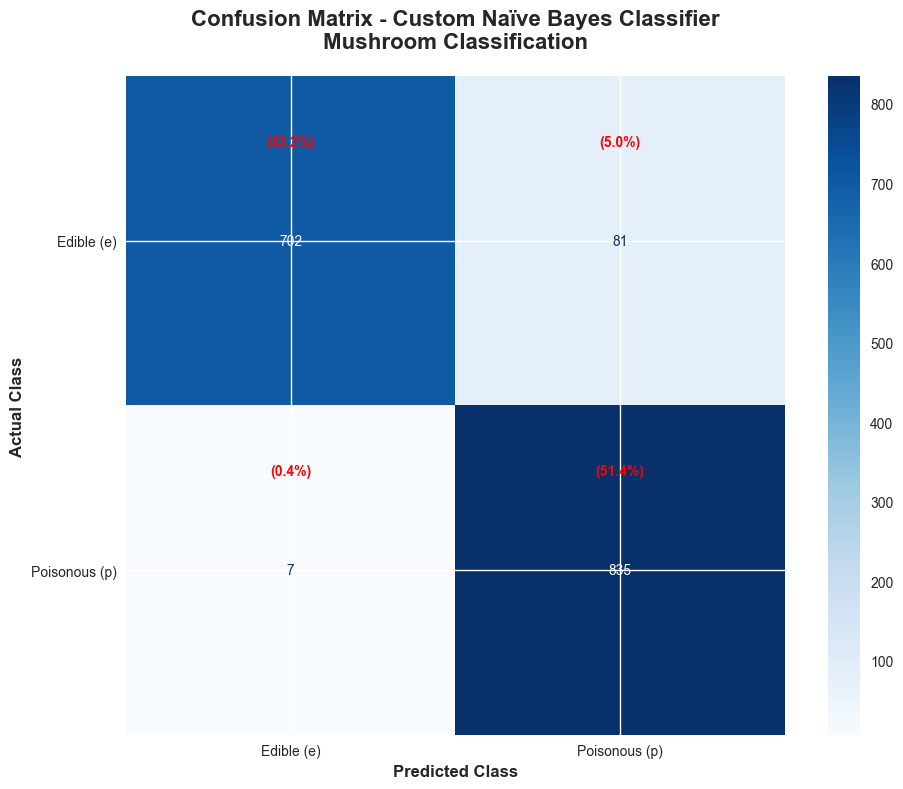


PERFORMANCE INTERPRETATION:
--------------------------------------------------
• False Positive Rate (Edible → Poisonous): 0.1034 (10.34%)
• False Negative Rate (Poisonous → Edible): 0.0083 (0.83%)
• Total Misclassified: 88 out of 1625 samples
Good: More conservative classification (fewer dangerous misclassifications)

SAMPLE PREDICTIONS WITH PROBABILITIES:
------------------------------------------------------------
Showing predictions for 5 random test samples:

Sample 1: (Index 135)
  Actual: Poisonous (p)
  Predicted: Poisonous (p)
  Confidence: Poisonous=1.0000 Edible=0.0000  → CORRECT

Sample 2: (Index 481)
  Actual: Edible (e)
  Predicted: Edible (e)
  Confidence: Poisonous=0.0000 Edible=1.0000  → CORRECT

Sample 3: (Index 836)
  Actual: Poisonous (p)
  Predicted: Poisonous (p)
  Confidence: Poisonous=1.0000 Edible=0.0000  → CORRECT

Sample 4: (Index 1227)
  Actual: Edible (e)
  Predicted: Edible (e)
  Confidence: Poisonous=0.0001 Edible=0.9999  → CORRECT

Sample 5: (Index 629)

In [26]:
# Evaluate the Custom Naïve Bayes Classifier - Complete Performance Analysis

print("=" * 70)
print("EVALUATING CUSTOM NAÏVE BAYES CLASSIFIER")
print("=" * 70)

# Make predictions on the test set (show detailed calculations for first few samples)
print("\nMaking predictions on test set...")
print("(Showing detailed calculations for first 2 samples for demonstration)\n")

y_pred = custom_nb.predict(X_test, verbose=True)

print("\n" + "=" * 70)
print("PERFORMANCE METRICS")
print("=" * 70)

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nOVERALL ACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=custom_nb.classes)

print(f"\nCONFUSION MATRIX:")
print("-" * 40)
print("Actual vs Predicted:")
print(f"{'':>12} {'Predicted':>20}")
print(f"{'Actual':>8} {custom_nb.classes[0]:>8} {custom_nb.classes[1]:>8} {'Total':>8}")
print("-" * 40)
for i, actual_class in enumerate(custom_nb.classes):
    row_total = np.sum(cm[i, :])
    print(f"  {actual_class:>4}   {cm[i,0]:>8} {cm[i,1]:>8} {row_total:>8}")
print("-" * 40)
col_totals = np.sum(cm, axis=0)
total_samples = np.sum(cm)
print(f"{'Total':>8} {col_totals[0]:>8} {col_totals[1]:>8} {total_samples:>8}")

# Calculate and display detailed performance metrics
print(f"\nDETAILED PERFORMANCE METRICS:")
print("-" * 50)

# Get classification report as dictionary for detailed analysis
from sklearn.metrics import precision_recall_fscore_support

# Calculate metrics for each class
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, labels=custom_nb.classes)

print(f"{'Class':<10} {'Precision':<12} {'Recall':<10} {'F1-Score':<10} {'Support':<8}")
print("-" * 50)

for i, class_label in enumerate(custom_nb.classes):
    class_name = "Edible" if class_label == 'e' else "Poisonous"
    print(f"{class_name:<10} {precision[i]:<12.4f} {recall[i]:<10.4f} {f1[i]:<10.4f} {support[i]:<8}")

# Calculate macro and weighted averages
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1)

weighted_precision = np.average(precision, weights=support)
weighted_recall = np.average(recall, weights=support)
weighted_f1 = np.average(f1, weights=support)

print("-" * 50)
print(f"{'Macro Avg':<10} {macro_precision:<12.4f} {macro_recall:<10.4f} {macro_f1:<10.4f} {np.sum(support):<8}")
print(f"{'Weighted Avg':<10} {weighted_precision:<12.4f} {weighted_recall:<10.4f} {weighted_f1:<10.4f} {np.sum(support):<8}")

# Print complete sklearn classification report for verification
print(f"\nSKLEARN CLASSIFICATION REPORT:")
print("-" * 50)
print(classification_report(y_test, y_pred, target_names=['Edible', 'Poisonous'], digits=4))

# Display confusion matrix as a plot
print(f"\nCONFUSION MATRIX VISUALIZATION:")
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Edible (e)', 'Poisonous (p)'])
disp.plot(cmap="Blues", ax=ax, values_format='d')
plt.title("Confusion Matrix - Custom Naïve Bayes Classifier\nMushroom Classification", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Predicted Class", fontsize=12, fontweight='bold')
plt.ylabel("Actual Class", fontsize=12, fontweight='bold')

# Add percentage annotations
for i in range(len(custom_nb.classes)):
    for j in range(len(custom_nb.classes)):
        percentage = (cm[i, j] / np.sum(cm)) * 100
        ax.text(j, i-0.3, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='red', fontweight='bold')

plt.tight_layout()
plt.show()

# Performance interpretation
print(f"\nPERFORMANCE INTERPRETATION:")
print("-" * 50)

# Calculate error rates
false_positive_rate = cm[0, 1] / (cm[0, 0] + cm[0, 1])  # Edible classified as Poisonous
false_negative_rate = cm[1, 0] / (cm[1, 0] + cm[1, 1])  # Poisonous classified as Edible

print(f"• False Positive Rate (Edible → Poisonous): {false_positive_rate:.4f} ({false_positive_rate*100:.2f}%)")
print(f"• False Negative Rate (Poisonous → Edible): {false_negative_rate:.4f} ({false_negative_rate*100:.2f}%)")
print(f"• Total Misclassified: {cm[0,1] + cm[1,0]} out of {total_samples} samples")

if false_negative_rate > false_positive_rate:
    print("WARNING: More poisonous mushrooms misclassified as edible than vice versa!")
else:
    print("Good: More conservative classification (fewer dangerous misclassifications)")

# Show some example predictions with probabilities
print(f"\nSAMPLE PREDICTIONS WITH PROBABILITIES:")
print("-" * 60)
print("Showing predictions for 5 random test samples:\n")

# Set random seed for reproducible results
np.random.seed(42)
random_indices = np.random.choice(len(X_test), 5, replace=False)

for i, idx in enumerate(random_indices):
    sample = X_test.iloc[idx]
    actual = y_test.iloc[idx]
    predicted, probabilities = custom_nb.predict_single(sample, verbose=False)
    
    actual_name = "Edible" if actual == 'e' else "Poisonous"
    predicted_name = "Edible" if predicted == 'e' else "Poisonous"
    
    print(f"Sample {i+1}: (Index {idx})")
    print(f"  Actual: {actual_name} ({actual})")
    print(f"  Predicted: {predicted_name} ({predicted})")
    print(f"  Confidence: ", end="")
    for class_val, prob in probabilities.items():
        class_name = "Edible" if class_val == 'e' else "Poisonous"
        print(f"{class_name}={prob:.4f} ", end="")
    
    status = "CORRECT" if predicted == actual else "WRONG"
    if predicted != actual:
        if actual == 'p' and predicted == 'e':
            status += " (DANGEROUS: Poisonous classified as Edible!)"
        else:
            status += " (Safe error: Edible classified as Poisonous)"
    
    print(f" → {status}")
    print()

print("=" * 70)
print("EVALUATION COMPLETE")
print("=" * 70)

# Final Model Accuracy Summary
print("\n" + "=" * 70)
print("FINAL MODEL ACCURACY SUMMARY")
print("=" * 70)
print(f"\nMODEL ACCURACY: {accuracy:.6f}")
print(f"PERCENTAGE ACCURACY: {accuracy*100:.4f}%")
print(f"CORRECT PREDICTIONS: {int(accuracy * total_samples)} out of {total_samples}")
print(f"INCORRECT PREDICTIONS: {total_samples - int(accuracy * total_samples)} out of {total_samples}")
print("\n" + "=" * 70)
print("Custom Naïve Bayes Classifier Performance Complete!")
print("=" * 70)